In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import highpass_fir, matched_filter, match
%matplotlib inline

In [6]:
hstrain = frame.read_frame('../Data/H-H1_LOSC_4_V1-1126076416-4096.gwf', 'H1:LOSC-STRAIN')
lstrain = frame.read_frame('../Data/L-L1_LOSC_4_V1-1126076416-4096.gwf', 'L1:LOSC-STRAIN')

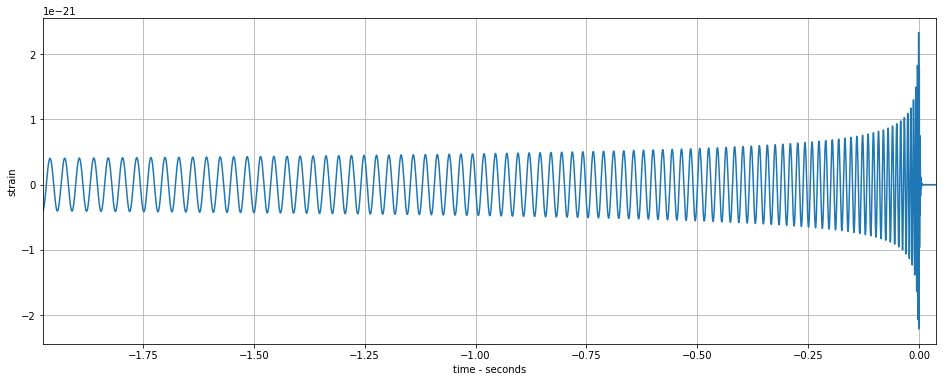

In [7]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=10, mass2=10, delta_t=hstrain.delta_t, f_lower=30, distance = 100)

#Plot both polarisations and the fake signal
plt.figure(figsize=(16, 6))
plt.plot(hp.sample_times, hp)
plt.xlim([hp.sample_times[0], hp.sample_times[-1]])
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

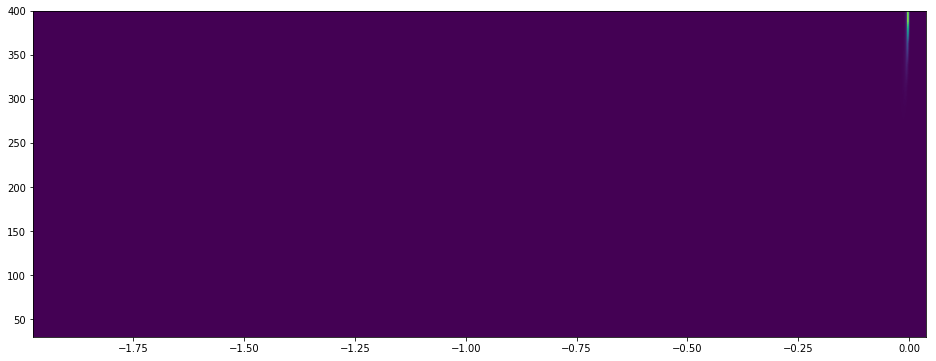

In [17]:
t, f, q = hp.qtransform(hp.delta_t, logfsteps=500, frange=(30, 400))
plt.figure(figsize=(16, 6))
plt.imshow(q, cmap='viridis', origin='lower', aspect='auto', extent=[t[0], t[-1], f[0], f[-1]])